# Virtual Directed Evolution Analysis

## Contents
## Overview
- `evo/bm3/main.py` was run with two *fitness* functions, $A$ & $B$ on a `g6-dedicated-50` linode instance each. 
    - The program uses virtual directed evolution to identify mutants of P450 BM3 to  hydroxylate the herbicide mesotrione at $C_5$.
    - The program uses a genetic algorithm to generate pools of BM3 active site mutants that are evaluated for *fitness* by predicting their structure and docking mesotrione into the active site.
    - The *fittest* mutants of each generation are used to repopulate the next by breeding via crossover and point mutation.

*Fitness* functions $A$ and $B$ were tested, which both vary on scoring: 
- The configuration of mesotrione in the predicted active site 
- The number of mutations relative to the starting sequence - *Hamming Distance*.

Results analysis here.

## Experimental Details
For each score, `evo/bm3/main.py` was run in eight instances using `evo/bm3/evo.sh` with the following configuration:

| Paramater | Value |
| --------- | ------|
| Population size | 128 |
| Survival rate | 0.25 |
| Docking Exhaustiveness | 16 |

Each `g6-dedicated-50` was provisioned with `evo/cloud/build-linode.sh` and the configuration scripts in `evo/cloud/config`.
Each experiment lasted about 3 days and cost $103. 
Data generated was structures, docking poses and scores for each mutant - it was compressed into a `.tar.gz` archive and uploaded to a linode bucket and the machines were terminated.

The eight replicates were run in parralell, generating 32,000 mutants for each experiment.

Score functions $A$ and $B$ were functions of the following metrics:
- **Affinity:** Each mutant generated eight mesotrione docking poses, each with a `vina` docking score - an estimate of binding energy $\Delta G$ in *kcac/mol*. $-10 < a < -1$
- **$C_5$ - Heme Iron Distance:** Distance in $\A$ of mesotrione $C_5$  to the heme iron for each pose. $5 < d < 30$
- **Hamming Distance w.r.t. BM3 A82F/F87V:** Number of mutations relative to the template. $0 < h < \text{n mutation sites}$

The progam aimed to minimize $a$ $d$ and $h$.
- Low $a$ and $d$ indicate that mesotrione binds tightly with $C_5$ close to the heme.
- Low $h$ is practical for constructing the best mutants by site-directed mutagenesis. 
- Low $h$ may also limits the chance of mutations with unpredictable, problematic effects.

### Score $A$

Uses the mean $a$ and $d$ between all poses - `dist_mean` & `aff_mean`.

$$ fn_A(a, d, h) = d - \log{|a|} - h $$

```python
def score_a(distances, affinities, hamming_dist):
    return np.mean(distances) - np.log(abs(affinities)) - hamming_dist

```
### Score $B$
Weighted average of $d$ by $softmax(a)$.

$$ fn_B(a, d, h) = (\frac{1}{n} \sum_{n}^{i} softmax(\log{|a|}_i)\times d_i) -  h $$

This weights more heavily the distances in the poses that bind tightly.

```python
# todo : code sample
```

## Data Description
The data analysed here are aggreagates of all repeats in experiements $A$ and $B$. 
Each holds data from 35,000 mutants.

The fields are:
- `gene` - a 25 character string containing letter codes for amino acids at mutation sites, maps to sites `[47, 49, 51, 75, 78, 88, 94, 138, 142, 175, 178, 184, 188, 205, 226, 252, 255, 260, 263, 290, 295, 328, 330, 350, 353]`
- `aff_mean` - mean `vina` affinity score across docking poses for each mutant
- `dist_mean` - mean $C_5$ - heme iron distance in  docking poses for each mutant
- `ham` - *Hamming* distance of mutant w.r.t the template gene - BM3 A82F/F87V

## Results
## Notebook


## Data Wrangling

Extracting the data from buckets:
```sh
$ linode-cli obj get james-engleback evoa-runs.tar.gz evob-runs.tar.gz
...
$ ls
evoa-runs.tar.gz/
evob-runs.tar.gz/
$ tar xfz *
$ ls
runs-a/
runs-b/
```
After extracting and concatenating:
```sh
'experiment-a/all-scores-a.csv'
'experiment-b/all-scores-b.csv'
```

# Initial Look at the Data

- [ ] Columns mislabelled
- [ ] Distributions of metrics
- [ ] Look at pairwise correlations
- [ ] TSNE

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

dfa = pd.read_csv('experiment-a/all-scores-a.csv')
dfb = pd.read_csv('experiment-b/all-scores-b.csv')

print(len(dfa))
print(len(dfb))

32791
32768


In [2]:
dfa.head()

,gene,aff_mean,dist_mean,score,ham,uid
0,RTYLVTKDPTVALFSERTIAAAAGL,-6.644444,8.968495,11.002474,1,odpyx
1,RTYLVTKHPTVALFSERTIAAAAGA,-6.377778,11.459518,13.457990,1,rrpba
2,RTYLVTKHPTVALFCERTIAAAAGL,-6.155556,12.072315,14.040204,1,ripnd
3,RTYLVTKTPTVALFSERTIAAAAGL,-6.722222,6.944881,8.988983,1,ltcfx
4,RTYLVTKHQTVALFSERTIAAAAGL,-6.377778,11.197797,13.196269,1,ftauu


In [3]:
dfb.head()

,gene,aff_mean,dist_mean,score,ham,uid
0,YTYLVTKHPTVALFSERTIAAAAGL,-6.077778,1.435890,13.810326,1,trndl
1,RGYLVTKHPTVALFSERTIAAAAGL,-6.677778,1.177079,11.440144,1,xvixg
2,RTYLVTKHPTVALFSERLIAAAAGL,-6.400000,1.199482,10.705550,1,qwaka
3,RTYLVTKHPTVALFSERTIAAANGL,-5.700000,1.658918,15.074071,1,nkude
4,RTYLVTKHPTVALFSERTIAAAAGQ,-6.666667,1.307910,11.364175,1,vxnfy


Column names are in the wrong order.
Should be:
$$
-10 < aff_{mean} < 0
$$
$$
0 < dist_{mean} 
$$
$$
score < dist_{mean}
$$

In [4]:
dfa.columns = ['gene', 'aff_mean','score', 'dist_mean',  'ham', 'uid']
dfb.columns = ['gene', 'aff_mean','score', 'dist_mean',  'ham', 'uid']

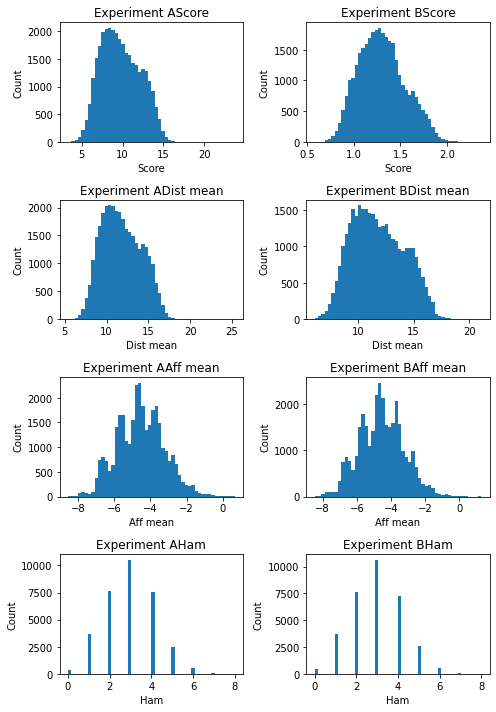

In [5]:
#plt.style.use('dark_background')
fig, ax = plt.subplots(4,2,figsize=(7,10))
cols = ['score', 'dist_mean', 'aff_mean', 'ham']
for col, plot, name in zip([df[i] for i in cols for df in [dfa, dfb]],\
                           ax.flatten(),
                           ['Experiment A', 'Experiment B']*4):
    plot.hist(col, bins=50)
    plot.set_xlabel(col.name)
    plot.set_ylabel('Count')
    plot.set_xlabel(col.name.replace('_',' ').capitalize())
    plot.set_title(name + col.name.replace('_',' ').capitalize())
plt.tight_layout()
plt.savefig(f'hists-{name}.png')
plt.savefig('img/exp-a-b-compr-dists.png')
plt.show()

## Distributions

### Comparison 
Experiment A and B look similar.

### Hamming Distance
`ham` - Hamming distance of a mutant w.r.t the template gene.
It tends towards 3 in both runs, which is good in terms of constructing mutants via site-directed mutagenesis.

`ham` was constrained via the score function.

### Affinity
`aff_mean` - the mean affinity score calculated by `vina` across all poses for the mutant.
Looks fairly normally distributed with a mean of around -4.

### Heme-C<sub>5</sub> Distance
### Score

## Distributions & Pairwise Correlations

## Experiment A
- `score` correlates 1:1 with `dist_mean` - reflects the score function used
- `ham` correlates very well with `aff_mean` - as `ham` increases `aff_mean` increases (gets worse)
- `aff_mean` seems to have clusters - probably corresponds to popular docking poses

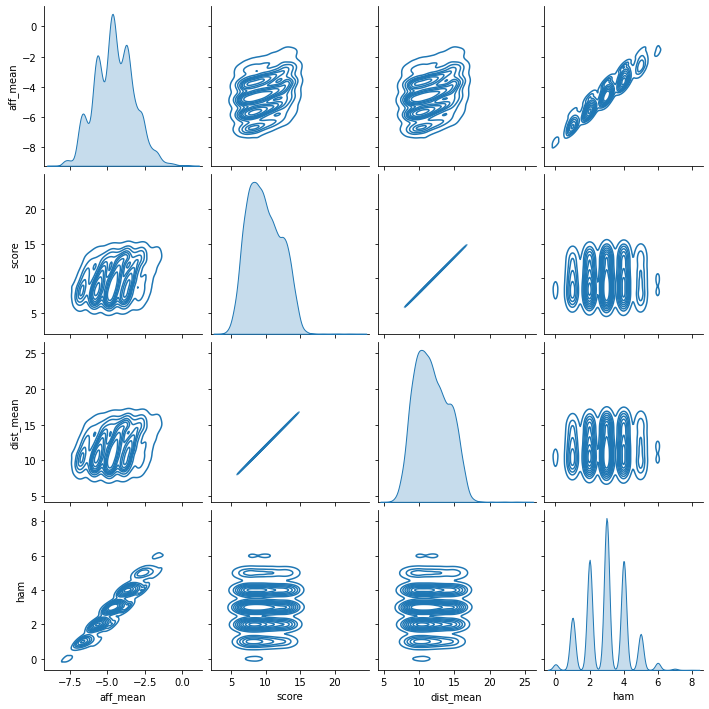

CPU times: user 5min 31s, sys: 714 ms, total: 5min 32s
Wall time: 5min 8s


In [6]:
%%time
import seaborn as sns

sns.pairplot(dfa, kind='kde')
plt.savefig('img/pairplot-dfa.png')
plt.show()

## Experiment B
Similar story here.
- `score` doesn't have as tight a correlation with `dist_mean` - but still pretty tight

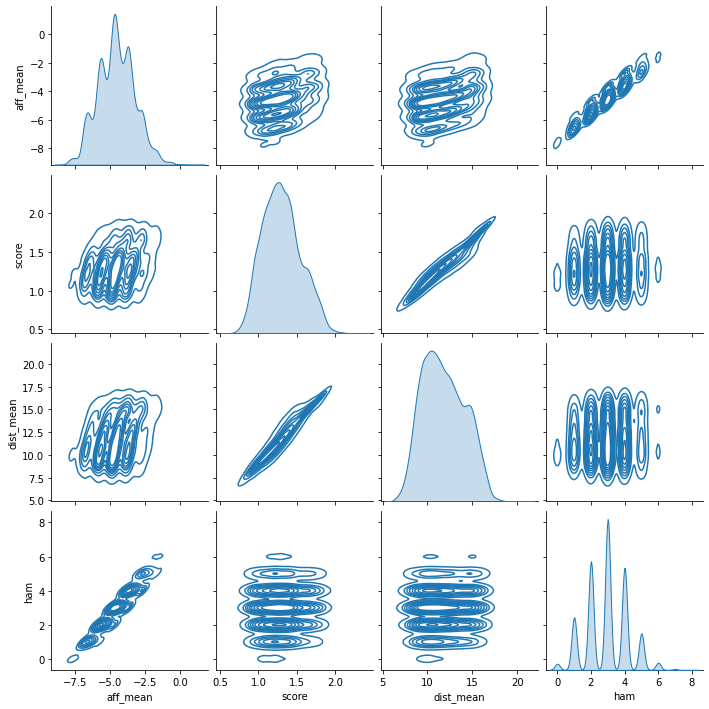

In [7]:
sns.pairplot(dfb, kind='kde')
plt.savefig('img/pairplot-dfb.png')
plt.show()

## Does Value Count Correlate with Score?

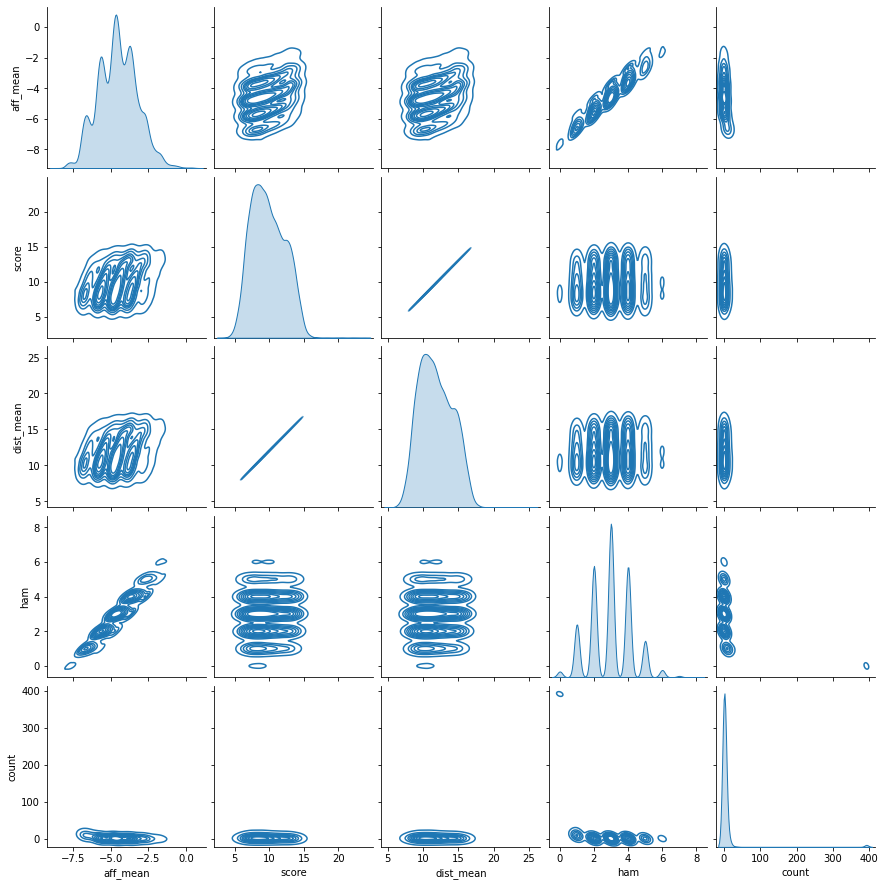

In [8]:
import seaborn as sns
d = dfa.gene.value_counts().to_dict()
dfa_ = dfa.copy()
dfa_['count'] = dfa.gene.apply(lambda gene : d[gene])
sns.pairplot(dfa_,kind='kde')
plt.show()

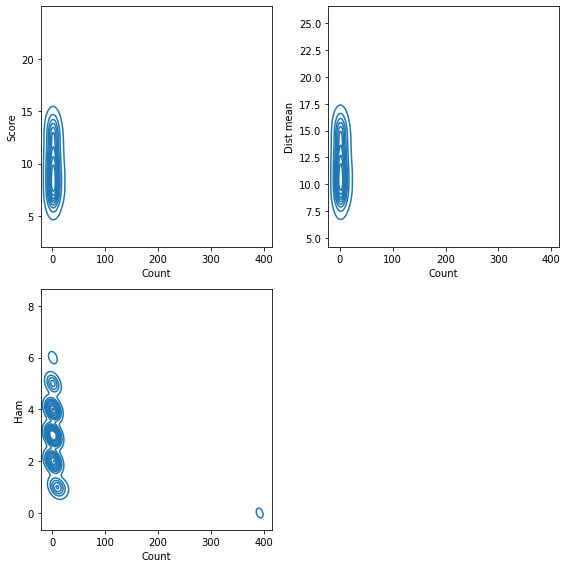

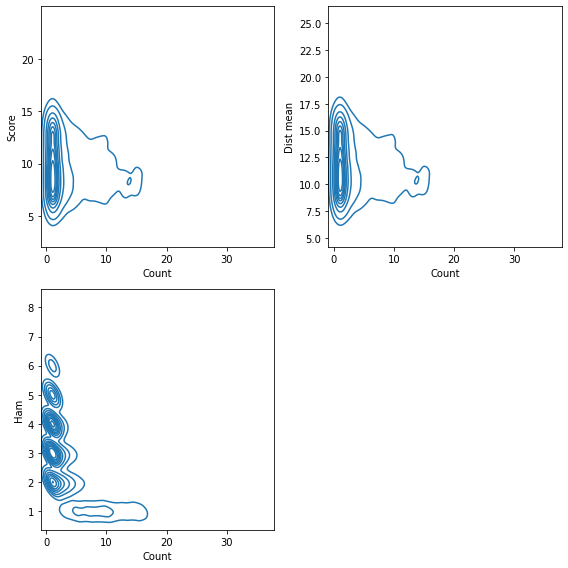

In [9]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
for i, j in zip(ax.flatten(), ['score', 'dist_mean', 'ham']):
    #i.scatter(dfa_['count'], dfa_[j], s=1)
    sns.kdeplot(x=dfa_['count'], y=dfa_[j], ax=i)
    i.set_xlabel('Count')
    i.set_ylabel(j.replace('_',' ').capitalize())
    #i.set_xscale('log')
ax[1][1].axis('off')
plt.tight_layout()
plt.savefig('img/kde-valcount-pair-expa.png')
plt.show()

dfa__ = dfa_.loc[dfa_['count']<300, :]
fig, ax = plt.subplots(2,2, figsize=(8,8))
for i, j in zip(ax.flatten(), ['score', 'dist_mean', 'ham']):
    #i.scatter(dfa_['count'], dfa_[j], s=1)
    sns.kdeplot(x=dfa__['count'], y=dfa_[j], ax=i)
    i.set_xlabel('Count')
    i.set_ylabel(j.replace('_',' ').capitalize())
    #i.set_xscale('log')
ax[1][1].axis('off')
plt.tight_layout()
plt.savefig('img/kde-valcount-pair-expa-clipped.png')
plt.show()

## Duplicates
76% of the sequences are unique.

In [10]:
df_ = pd.concat([dfa, dfb])
print(len(dfa.gene.unique()) / len(dfa))
print(len(dfa.gene.unique()) / len(dfa))
print(len(df_.gene.unique()) / len(df_))

0.7788417553597023
0.7788417553597023
0.763876813252185


In [11]:
duplicates = df_.loc[df_.gene.duplicated(),:]
print(len(duplicates))
print(len(duplicates.gene.unique()))

15480
5991


In [12]:
val_counts = duplicates.gene.value_counts()
val_counts

RTYLVTKHPTVALFSERTIAAAAGL    826
RTYLVTKRPTVALFSERTIAAAAGL     43
RTYLVFKHPTVALFSERTIAAAAGL     41
RTYLVTKHPTVASFSERTIAAAAGL     39
RTYLVTKHPTVANFSERTIAAAAGL     37
                            ... 
RTYLVTKHPLVALFSERSIAGAAGL      1
RPYLVTKHPTVALFEERTIAQAAGL      1
RTNLVTTHPTVALFSERTIAAAAGL      1
RTYLVNKHPTVALFIERTIAAAAGI      1
RTYLVTKHPTVALFFERTHAAAAGL      1
Name: gene, Length: 5991, dtype: int64

The most popular gene at 826 is the template.
The number of initial templates is 16, so the template is revisted a lot.
Probably because of the `ham` constraint.

In [13]:
template_gene = val_counts.index[val_counts.argmax()]
set(df_.loc[df_.gene == template_gene, 'ham'])

{0}

## Template duplicates
There are 826 duplicates of the template gene across both experiments.
Scores not plotted for the aggregation of both experiments.

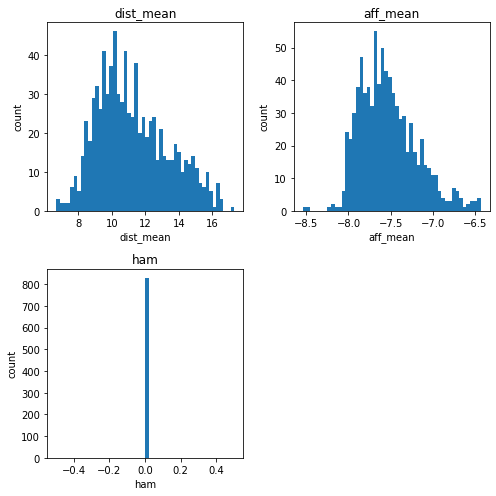

In [14]:
template = df_.loc[df_.gene == template_gene, :]
fig, ax = plt.subplots(2,2,figsize=(7,7))
cols = ['dist_mean', 'aff_mean', 'ham']
for col, plot in zip([template[i] for i in cols],\
                      ax.flatten()):
    plot.hist(col, bins=50)
    plot.set_xlabel(col.name)
    plot.set_ylabel('count')
    plot.set_title(col.name)
ax[1][1].set_axis_off()
plt.tight_layout()
plt.savefig(f'img/hists-template-gene.png')
plt.show()

## TSNEs
Run with `tsne.py`

In [15]:
tsa = pd.read_csv('tsne-a.csv', index_col=0)
tsb = pd.read_csv('tsne-b.csv', index_col=0)
tsb.head()

,0,1
0,-2.372991,-3.393541
1,-16.840439,-6.954678
2,18.324680,-16.444464
3,8.079386,-3.024531
4,7.071154,10.529802


## Experiment A
- Hamming distance is 0 in the middle - that's where the template is
- Affinity score is also low there, which suggests the template and maybe mutants close to it bind mesotrione tightly
- Theres a cluster on the left with a good (low) score around 5-7 - need to look at that

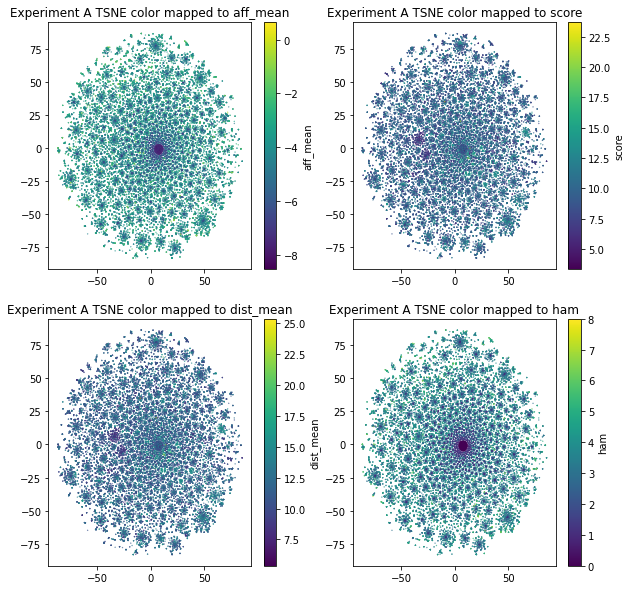

In [16]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
cols = ['aff_mean', 'score', 'dist_mean', 'ham']
for i, j in zip(cols, ax.flatten()):
    plot = j.scatter(x=tsa['0'], 
                     y=tsa['1'],
                     s=0.1,
                     c=dfa[i],
                     )
    j.set_title(f'Experiment A TSNE color mapped to {i}')
    fig.colorbar(plot, ax=j, label=i)

plt.savefig('img/tsne-a.png')
plt.show()

## Experiment B
Similar story here except no cluster that's clearly better than the others - except maybe that one in the top left.

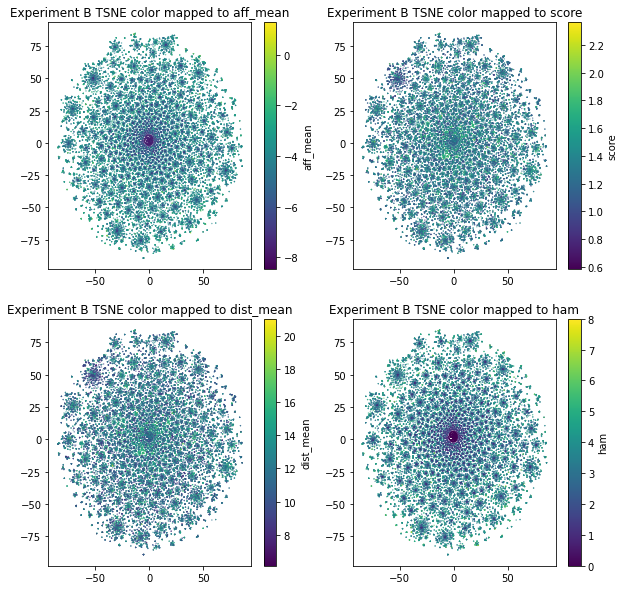

In [17]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
cols = ['aff_mean', 'score', 'dist_mean', 'ham']
for i, j in zip(cols, ax.flatten()):
    plot = j.scatter(x=tsb['0'], 
                     y=tsb['1'],
                     s=0.1,
                     c=dfb[i],
                     )
    j.set_title(f'Experiment B TSNE color mapped to {i}')
    fig.colorbar(plot, ax=j, label=i)

plt.savefig('img/tsne-b.png')
plt.show()

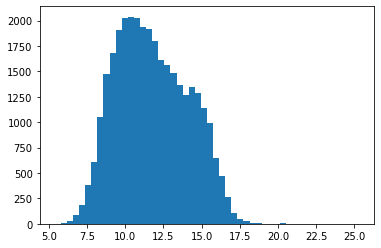

In [18]:
plt.hist(dfa.dist_mean, bins=50)
plt.savefig('img/dist-mean-a-distr.png')
plt.show()

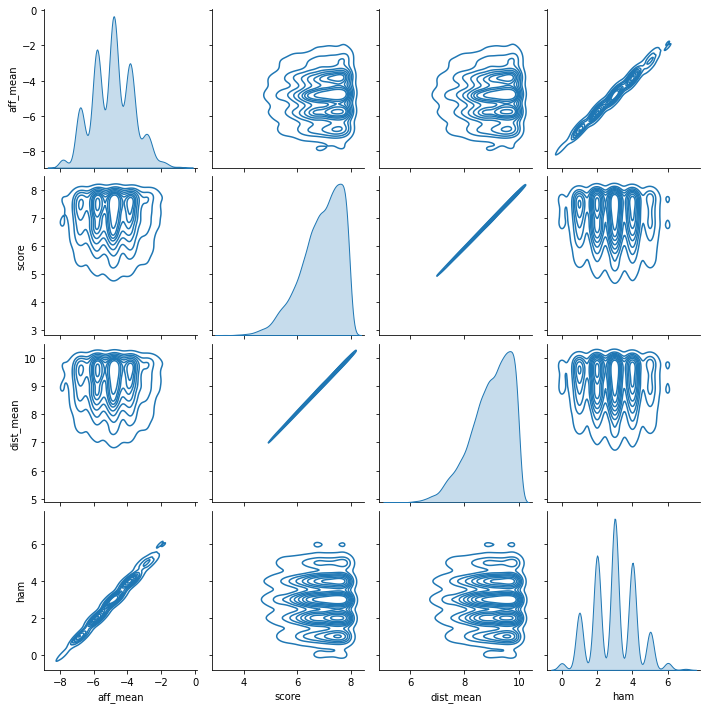

In [19]:
ba = dfa.loc[dfa.dist_mean < 10,:]
sns.pairplot(ba, kind='kde')
plt.savefig('img/pairplot-a-dist-lt-10A.png')
plt.show()

## Pareto front?
3 mutations might be ok?
Template is the most populer

In [20]:
ba_vc = ba.gene.value_counts()
ba_vc

RTYLVTKHPTVALFSERTIAAAAGL    120
RTYLVTKRPTVALFSERTIAAAAGL     14
RTYGVTKHPTVALFSERTIAAAAGL     13
RTYPVTKHPTVALFSERTIAAAAGL     11
RTYLVLKHPTVALFSERTIAAAAGL     10
                            ... 
RTYLVTKHDPVALASECTIAAAADL      1
RTYLVTGHPTVAAFSENTIAAAAGL      1
RTQLVTKHPTVALWSEGTIAAAADL      1
RTYLVTKHRYVALFSECTIAAAAGL      1
RTYLVLPHPTVALFSERTIKAAAGL      1
Name: gene, Length: 7323, dtype: int64

In [21]:
ba_vc.index[0] == template_gene

True

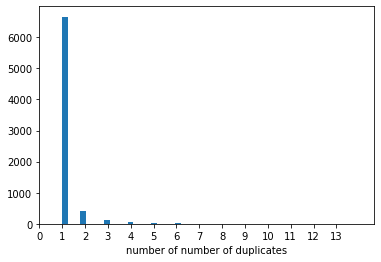

In [22]:
plt.hist(ba_vc[1:],bins=50)
plt.xlabel('number of number of duplicates')
#plt.xscale('log')
plt.xticks(range(14),range(14))
plt.savefig('img/num-uniq-ab-hist.png')
plt.show()

In [23]:
x = ba_vc.loc[ba_vc > 3]
x

RTYLVTKHPTVALFSERTIAAAAGL    120
RTYLVTKRPTVALFSERTIAAAAGL     14
RTYGVTKHPTVALFSERTIAAAAGL     13
RTYPVTKHPTVALFSERTIAAAAGL     11
RTYLVLKHPTVALFSERTIAAAAGL     10
                            ... 
RRYLVTKHPTVALFSERTIAAAAGL      4
RTYLVTKHPTNALFSERTIAAAAGL      4
RTYLVTNHPTVALFSERTIAAAAGL      4
KTYLVTKHPTVALFSERTIAAAAGL      4
RTYLVTKHPFVALFSERTIAAAAGL      4
Name: gene, Length: 110, dtype: int64

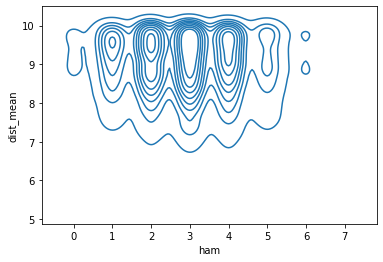

In [24]:
sns.kdeplot(x=ba.ham, 
            y=ba.dist_mean)
plt.savefig('img/kde-dist-ham-ab.png')
plt.show()

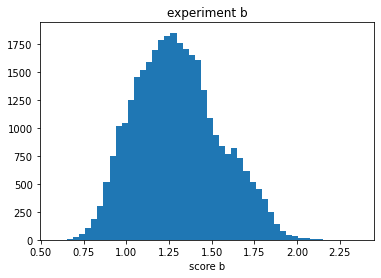

In [25]:
plt.hist(dfb.score, bins=50)
plt.xlabel('score b')
plt.title('experiment b')
plt.savefig('img/hist-scoreb-b.png')
plt.show()

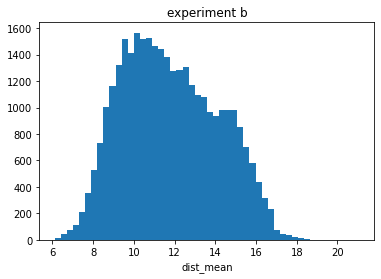

In [26]:
plt.hist(dfb.dist_mean, bins=50)
plt.xlabel('dist_mean')
plt.title('experiment b')
plt.savefig('img/hist-dist-b.png')
plt.show()

In [27]:
bb = dfb.loc[dfb.dist_mean < 10, :]
bb

,gene,aff_mean,score,dist_mean,ham,uid
8,RTYLVTKHPTVALFSERVIAAAAGL,-6.800000,1.102021,9.690085,1,aeose
11,RTYLVTKHPTVALFSERTIAAAAGL,-7.833333,1.105123,9.710878,0,xlvpi
12,RTYLVTKHPTVPLFSERTIAAAAGL,-6.866667,1.075939,9.600841,1,emxjh
13,RTYLVTKHPTVALESERTIAAAAGL,-6.511111,1.156873,9.639508,1,tupjx
19,RTYLVTKHPTVALFSMRTIAAAAGL,-6.677778,1.075496,9.105535,1,orepb
...,...,...,...,...,...,...
32748,RTYTVTKHPCVALFSERTIAAAAKL,-4.577778,1.209347,9.861749,3,znpmt
32749,RTYLVFKNPTVALFSERTIAGAAGL,-5.055556,1.022449,9.707138,3,tiofe
32753,RTYSVTKRPGTALFSERTIAAAAGL,-4.044444,0.900862,8.150650,4,qwgbq
32757,RTYLVTKPATDALFSEDTIAAAAGL,-3.900000,0.904599,8.567520,4,rprgh


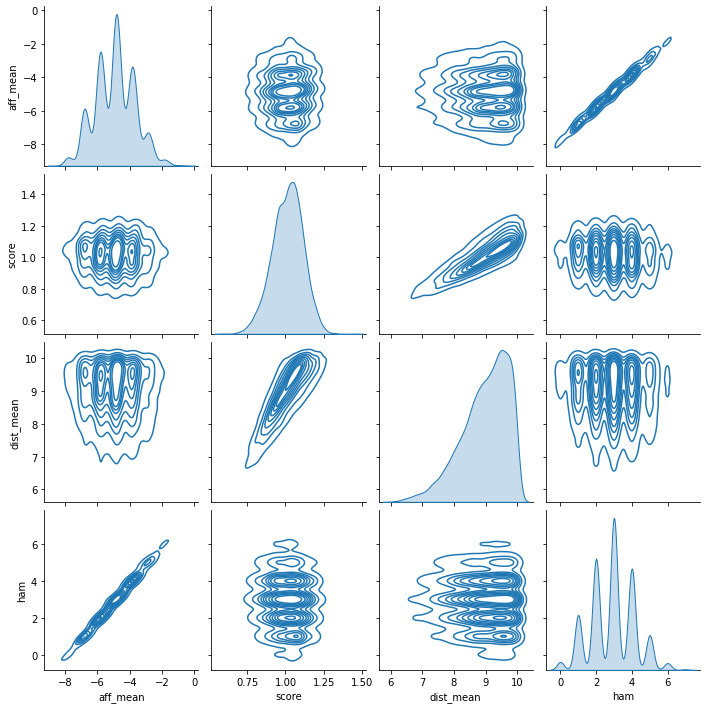

In [28]:
sns.pairplot(bb,kind='kde')
plt.savefig('img/kde-pairplot-ab.png')
plt.show()

In [29]:
bb

,gene,aff_mean,score,dist_mean,ham,uid
8,RTYLVTKHPTVALFSERVIAAAAGL,-6.800000,1.102021,9.690085,1,aeose
11,RTYLVTKHPTVALFSERTIAAAAGL,-7.833333,1.105123,9.710878,0,xlvpi
12,RTYLVTKHPTVPLFSERTIAAAAGL,-6.866667,1.075939,9.600841,1,emxjh
13,RTYLVTKHPTVALESERTIAAAAGL,-6.511111,1.156873,9.639508,1,tupjx
19,RTYLVTKHPTVALFSMRTIAAAAGL,-6.677778,1.075496,9.105535,1,orepb
...,...,...,...,...,...,...
32748,RTYTVTKHPCVALFSERTIAAAAKL,-4.577778,1.209347,9.861749,3,znpmt
32749,RTYLVFKNPTVALFSERTIAGAAGL,-5.055556,1.022449,9.707138,3,tiofe
32753,RTYSVTKRPGTALFSERTIAAAAGL,-4.044444,0.900862,8.150650,4,qwgbq
32757,RTYLVTKPATDALFSEDTIAAAAGL,-3.900000,0.904599,8.567520,4,rprgh


In [30]:
bb.gene.value_counts()

RTYLVTKHPTVALFSERTIAAAAGL    144
RTYSVTKHPTVALFSERTIAAAAGL     19
RTYLVFKHPTVALFSERTIAAAAGL     15
RTYLGTKHPTVALFSERTIAAAAGL      8
RTYLVTKQPTVALFSERTIAAAAGL      8
                            ... 
RTYLVTNHPKVALISEETIAAAAGL      1
RTYLVTKHRTVKLFSERTIAAAAGL      1
RTYLVTKHPTVKLFSERFIAAAAGL      1
RTDLVTKHPTIALFSERTIAAAAGF      1
RTYSVTKRPTTALFSEDTIAAAAGV      1
Name: gene, Length: 7255, dtype: int64

## Does value count correlate with fitness?

/home/u0/miniconda3/envs/sxfst/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


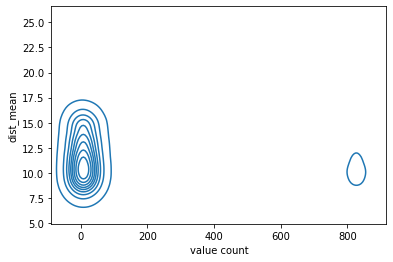

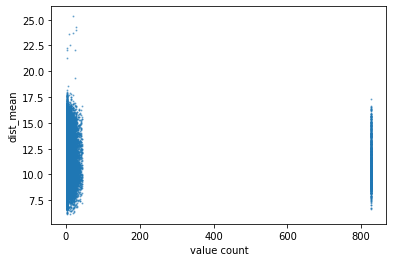

In [31]:
import numpy as np

vc = df_.gene.value_counts()
vc_ = vc.loc[vc > 1]
vc_fitness = {i:df_.loc[df_.gene == i, 'dist_mean'].tolist() \
              for i in vc_.index}

xy = np.array(\
              [[i,k] for i,j in zip(vc_, vc_.index) \
                   for k in vc_fitness[j]]\
             )
sns.kdeplot(xy[:,0], xy[:,1])
plt.ylabel('dist_mean')
plt.xlabel('value count')
plt.show()

plt.scatter(xy[:,0], xy[:,1], s=1, alpha=0.5)
plt.ylabel('dist_mean')
plt.xlabel('value count')
plt.show()

/home/u0/miniconda3/envs/sxfst/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


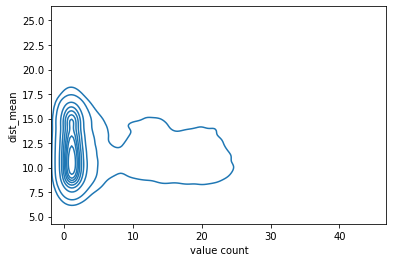

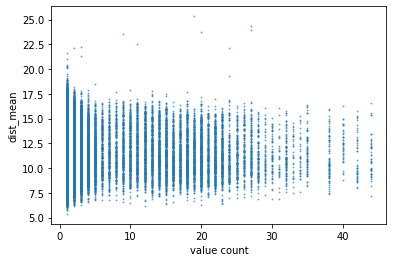

In [32]:
vc = df_.gene.value_counts()
vc_ = vc.loc[vc > 1]
vc_ = vc.loc[vc < vc_.max()]
vc_fitness = {i:df_.loc[df_.gene == i, 'dist_mean'].tolist() \
              for i in vc_.index}

xy = np.array(\
              [[i,k] for i,j in zip(vc_, vc_.index) \
                   for k in vc_fitness[j]]\
             )

sns.kdeplot(xy[:,0], xy[:,1])
plt.ylabel('dist_mean')
plt.xlabel('value count')
plt.show()

plt.scatter(xy[:,0], xy[:,1], s=1, alpha=0.5)
plt.ylabel('dist_mean')
plt.xlabel('value count')
plt.savefig('img/scatter-dist-val-count-ab.png')
plt.show()

## Sequence Logo
The template sequence predominates. Dang.

RTYLVTKHPTVALFSERTIAAAAGL
25
25


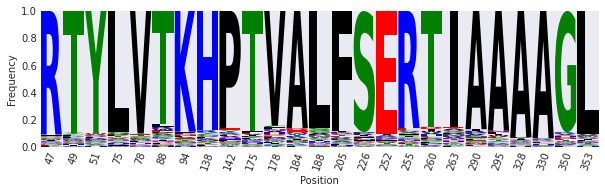

In [33]:
import logomaker

dfag = pd.DataFrame([list(i) for i in dfa.gene])
dfag_c = pd.concat([dfag[i].value_counts() for i in dfag],
         axis=1).fillna(0)
dfag_c /= dfag_c.sum(axis=0)

MXN_SITES = [47, 49, 51, 75, 78, 88, 94, 138, 142, 175, 178, 
             184, 188, 205, 226, 252, 255, 260, 263, 290, 295, 
             328, 330, 350, 353]

print(template_gene)
print(len(MXN_SITES))
print(len(template_gene))

plt.style.use('seaborn-dark')
logo = logomaker.Logo(dfag_c.T, color_scheme='chemistry')
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.xticks(range(len(MXN_SITES)), MXN_SITES, rotation=70)
plt.savefig('img/logo-ab.png')
plt.show()

,'count'## Model
`nn.py` was an attempt to model this dataset with a simple feed forward neural network, predicting `dist_mean`. 
Didn't go very well.

Options for continuing `nn.py`:
- Different normalization/scaling
- aggregate all old data from trial runs
- resample data for balancing
    - ???
- Feature engineering
    - aa embedding
- ESM transfer - need a GPU for that though. can prototype on a cpu machine.

Trying a random forest here

In [34]:
from numpy import concatenate as cat
from numpy import zeros 
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

def ohe(gene, dim=0):
    AAS = dict(zip('ACDEFGHIKLMNPQRSTVWY', range(20)))
    fn = lambda string : [AAS[i] for i in string]
    o = []
    for i in gene:
        x = zeros((1,len(AAS)))
        x[0, fn(i)] = 1.
        o.append(x)
    return cat(o, axis=dim)

def min_max_scale(x):
    x_ = x - min(x)
    x_ = x_ / max(x_)
    return x_

x = cat([ohe(i,dim=1) for i in df_.gene])
y = min_max_scale(df_.dist_mean)
print(x.shape)
print(y.shape)

(65559, 500)
(65559,)


## Could normalize that better

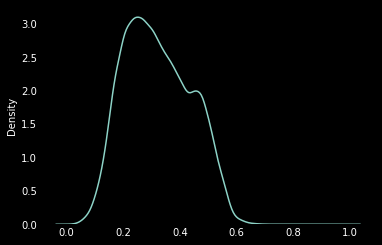

In [35]:
plt.style.use('dark_background')
sns.kdeplot(y.values)
plt.savefig('img/dist-mmscale-dist-ab.png')
plt.show()

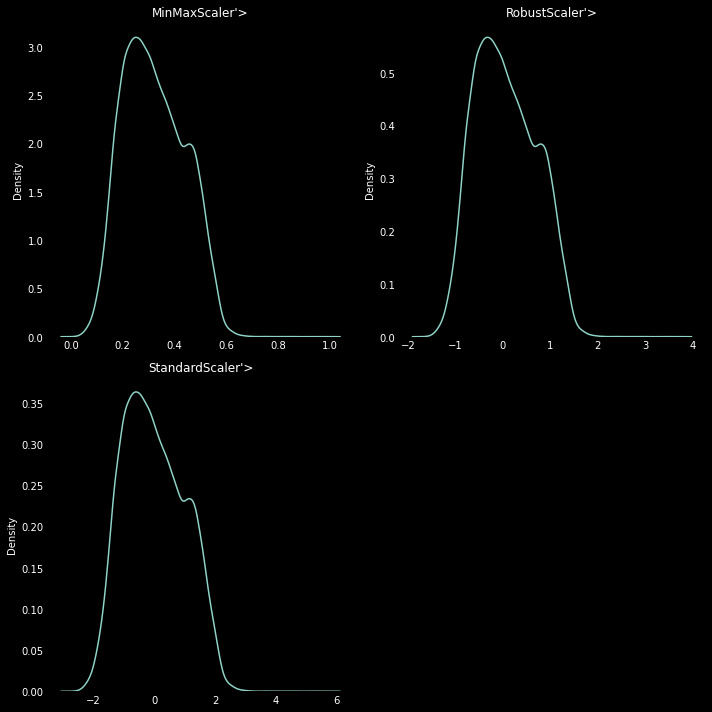

In [36]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
plt.style.use('dark_background')
l = [MinMaxScaler, RobustScaler, StandardScaler]
fig, ax = plt.subplots(2,2, figsize=(10,10))
for i, j in zip(l, ax.flatten()):
    scaler = i()
    y_ = scaler.fit_transform(df_[['dist_mean']].values)
    sns.kdeplot(y_.reshape(-1), ax=j)
    j.set_title(str(i).split('.')[-1])
ax[1][1].set_axis_off()
plt.tight_layout()
plt.savefig('img/dists-normalizer-comparison.png')
plt.show()

In [37]:
from sklearn.model_selection import train_test_split


x_train, xtest, y_train, y_test = train_test_split(x,y, test_size=0.25)
model.fit(x_train,y_train)

RandomForestRegressor()

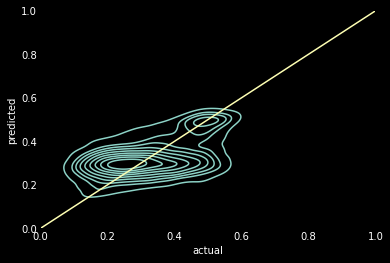

In [38]:
yh_test = model.predict(xtest)
plt.style.use('dark_background')
sns.kdeplot(x=y_test.values, y=yh_test)
plt.plot([0,1],[0,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.savefig('img/kde-rf-accuracy.png')
plt.show()

In [39]:
from einops import rearrange

arr = rearrange(model.feature_importances_, '(a b) -> a b', a=20, b=25)

sns.heatmap(arr)
plt.xticks(range(len(MXN_SITES)), MXN_SITES, rotation=70)
plt.yticks(range(20), list('ACDEFGHIKLMNPQRSTVWY'))
plt.savefig('img/heatmap-rf-feature-importnace-ab.png')
plt.show()

ModuleNotFoundError: No module named 'einops'

In [ ]:
import numpy as np

def ens_pred(model, x):
    return np.array([i.predict(x) for i in model.estimators_]).T

print(xtest.shape)
ens_pred(model, xtest).shape

In [ ]:
def check(n):
    sns.kdeplot(ens_pred(model,xtest[n].reshape(1,-1)).reshape(-1))
    plt.vlines(x=y_test.values[n], 
               ymin=0,
               ymax=16,
               label='actual')
    plt.vlines(x=model.predict(xtest[n].reshape(1,- 1)), 
               ymin=0,
               ymax=16,
               linestyles='--')
    plt.xlim(0,1)
    
import random
for _ in range(10):
    check(random.randint(0, len(y_test)))
plt.savefig('img/kde-rf-cert-ab.png')
plt.show()